## <center> Facial Recognition with Keras, FaceNet, Inception model and transfer learning</center> 

Facial recognition is the task of looking at an image showing the face of a person and being able to identify that person from a collectiong of images already present in a database.  

- the system has a database of n persons (images for each of them, most often just 1 per person, if were talking about a database of employee profile pictures)
- the system receives as input a new, unseen, image of that person (maybe it's them checking in at the security desk every morning)
- and should be able to recognize if this is any of the n persons already present in the database. 

To build such a system, I will make use of:
- <a href='https://en.wikipedia.org/wiki/Siamese_neural_network'>Siamese Networks</a>
- the Triplet loss function, described in the <a href='https://arxiv.org/abs/1503.03832'>FaceNet article by Schroff et al 2015</a>
- <a href='https://www.tensorflow.org/tutorials/images/transfer_learning'>Transfer learning</a>, to save training time by making use of pretrained convolutional neural networks.
- Keras interface for the TensorFlow library and <a href='https://keras.io/api/applications/'>Keras Applications</a> pretrained models. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import sys
import random
import tensorflow as tf
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Tansfer learning

CNN models accuracy tends to increase with network complexity and training dataset size. This is a simplified summary of the general trend. Although in reality things are a bit more complicated (e.g. you can't train a very complex network on a not so large dataset because the model will overfit or the fact that networks beyond a certain depth become problematic), this simplification is a good enough approximation of the general trend. 

Taking for granted that more complex is generally better, which means more computing power/time needed for training, we come to realize we need very powerful machines to train large networks on large datasets (which can reach millions of images). 

Luckily, research groups / companies make available their already trained image models, so we don't have to spend weeks or months doing this work on our own, on a personal computer.  

These pre-trained and freely available image models are usually trained on some common datasets, also freely available, which most of these research groups / companies tend to use (like the <a href='https://imagenet.stanford.edu/'>ImageNet dataset</a>, which is used in the <a href='https://imagenet.stanford.edu/challenges/LSVRC/'>ImageNet Large-Scale Visual Recognition Challenge (ILSVRC))</a>.

These training datasets are often different than the images we want to use these models on. For example, in this notebook I will use a model trained on the ImageNet dataset to perform facial recognition. The ImageNet dataset contains approximately 1.2 million images for 1000 different objects (1000 classes), but none of them are faces. To be able to use this pre-trained model for my task, I will apply <a href='https://www.tensorflow.org/tutorials/images/transfer_learning'>transfer learning</a>. 

*Intuition behind Transfer Learning*

Transfer learning consists of freezing the parameters (weights and biases) of a pretrained model and retraining for the current task only the last layer(s). The intuition behind why this approach makes sense is that models trained on images learn features that are useful in any visual classification task, regardless on the particular images on which they were trained. 

<img src='https://mihaelagrigore.info/wp-content/uploads/2021/05/1-Regular-covolutional-neural-networks.png'/>

-- Figure 1: schematic depictiong of a basic convolutional neural network --

Figure 1 is a visualization for the intuition mentioned above. This is a schematic depiction of a simple CNN. As we progress through the network, an individual cell in a network's layer 'sees' (or receives information from) a wider patch of the network's input image. So we assume that deeper layers learn more complex patterns.

*What CNN layers learn*

Complementing the intuition above, <a href='https://arxiv.org/abs/1311.2901'>Zeiler and Fergus, 2013</a> introduced for the first time a method to see what CNNs layers are actually learning and proved what researchers already suspected was happening.  

<img src='https://mihaelagrigore.info/wp-content/uploads/2021/05/2-What-do-CNN-learn.png'/>
-- Figure 2: snippet of figures from the Zeiler and Fergus 2013 with cyan highlighting applied by myself --

Figure 2 is a snippet of one of the figures presented by Zeiler and Fergus 2013. The cyan highlight is my own addition and the figure is cropped, to prevent information overload and help us stay focused on a simple take home message. On the left we have activations of a neuron in a particular layer projected back to the input pixels space and on the right we have the original input patch that the particular neuron 'sees'. A more intuitive way to think of this is that we are looking at what patterns a neuron in a certain layer has a stronger response for. And we can see in the cyan highlight that a neuron in layer 2 is mostly activated by a vertical pattern, while the highlighted neuron in layer 5 responds to the shape of dog heads. 

## The Inception Model

So, I covered so far why we use pre-trained models and why transfer learning would work. Next I had to choose which model to use. I decided to use the Inception network model, introduced by <a href='https://arxiv.org/abs/1409.4842'>Szegedy et al 2014</a>. First, the Inception model is also the one chosen by the authors of the <a href='https://arxiv.org/abs/1503.03832'>FaceNet system</a>, which is the system I will use for facial recognition later on. Second, the Inception model introduced an interesting concept that should be studied by someone learning about Convolutional Neural Networks.  

Up until Inception, CNN models would normally use identically shaped filters in a certain layer. For example, in Figure 1, for the first layer, I used 6 filters of shape 3x3x3 and stacked their outputs together on the depths dimension. Inception would use 3 different filter shapes (1x1, 3x3 and 5x5) and a max pooling in the same layer. 

<img src='https://mihaelagrigore.info/wp-content/uploads/2021/05/3-Inception-CNN-model-1.png'/>
-- Figure 3: Inception module --

The Inception network is mostly composed of layers (Inception *modules*) with the structure shown in Figure 3. This figure is reproduced from the original article by <a ref='https://arxiv.org/abs/1409.4842'>Szegedy et al 2014</a>. The Inception *module* on the right contains additional 1x1 convolutions which have the role of reducing computational cost. Andrew Ng has a short video capsule explaining why this is the case, part of the course on CNN from the Deep Learning specialization offered by DeepLearning.ai on Coursera, also available on YouTube as <a href='https://www.youtube.com/watch?v=C86ZXvgpejM'>C4W2L06</a>.

## Keras Applications

For the implementation, I will use Keras. <a href='https://keras.io/api/applications/'>Keras Applications</a> makes available pre-trained deep learning models. I think this is more or less the same as <a href='https://github.com/tensorflow/models'>Tensorflow Model Garden</a>. So if you've used or heard of the TF Model garden before and now you're wondering why there's a Keras 'garden' too, especially since Keras is now the official high level API for Tensorflow 2, I think you can use either of the two. I decided to go with Keras because it's more convenient, easier to use and it offers everything I need for the purpose of this projects. 

<a href='https://keras.io/api/applications/'>Keras Applications</a> offers two versions of the Inception network: <a href='https://arxiv.org/abs/1512.00567'>InceptionV3</a> and InceptionResNetV2. which I assume is a mix of Inception and ResNet, but I will not go into ResNet in this Notebook, to keep complexity under control. I have a separate Notebook on Kaggle on <a href='https://www.kaggle.com/mishki/resnet-keras-code-from-scratch-train-on-gpu'>coding a ResNet from scratch using Keras</a>, if interested. These CNN models have been trained on the <a href='https://imagenet.stanford.edu/'>ImageNet dataset</a>.

Figure 4 shows a benchmark of popular deep neural network models for visual recognition. The graph shows Top-1 accuracy and model complexity. We can see that Inception V4 has one of the highest accuracies and relatively small complexity among networks that give similar results. Unfortunately, v4 is only available in the TF Model Garden, but not in Keras Applications. So I will settle to v3.
Figure 4 is reproduced from <a href='https://arxiv.org/pdf/1810.00736.pdf'>Bianco et al 2018</a>.

<img src='https://mihaelagrigore.info/wp-content/uploads/2021/04/Benchmark-of-representative-deep-neural-networks-architectures-small.jpg' style="width: 600px;"/>
-- Figure 4: Ball chart reporting the Top-1 accuracy vs. computational complexity of representative Deep Neural Network architectures --

Start by importing the pretrained model. For examples of how to get started with this handling this an Applications model I used the <a href='https://keras.io/api/applications/'>official documentation</a>.

I mentioned earlier that transfer learning consists of freezing the parameters (weights and biases) of a pretrained model and retraining for the current task only the last layer(s).  

I will load the pretrained InceptionV3 model (trained on the ImageNet dataset), but without the fully connected layer at the top (last layer in the network). This is the layer that outputs predictions for the ImageNet dataset. I then replace this layer with three more fully connected layers, to give the model a chance to learn new features for the image recognition task. And I define a new Model based on all these layers. To see how to work with Keras Models check out the <a href='https://keras.io/api/models/model/#model-class'>Model class documentation</a>.

For the first two fully connected layers I will apply Batch Normalization for reasons explained <a href='https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization'>here</a>

In [ ]:
target_size = (224, 224)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3,), include_top=False)

#uncomment the line below to see the layers structure of our network
#inception_model.summary()

In [ ]:
flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512, activation='relu')(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_2 = layers.Dense(256, activation='relu')(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
dense_layer_3 = layers.Dense(256, activation='relu')(dense_layer_2)

# next I specify which layers to 'freeze' and which layers to keep training
# freeze all convolutional InceptionV3 layers 
# and train only the layers I added at the top (initialized with random values)
for layer in inception_model.layers:
    layer.trainable = False

#define a model with the layers we've just connected
transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_3)

## Facial recognition

**One shot learning**

Facial recognition is a problem of the type <a href='https://en.wikipedia.org/wiki/One-shot_learning'>**one-shot learning**</a>. The model has to learn who this person is by only looking at one (new) picture of this person. The typical example here is that you're building a facial recognition system for the employees of a company and usually HR only has one picture for each employee. This is in contrast with tyical machine learning problem where a model learngs from hundreds or thousands of examples of a particular class.   

**One way to do facial recognition**  
To continue with the facial recognition for employes' accessing the building, a way to implement face recognition with CNN can be as in Figure 5 below. We train a CNN on our database of images (our 5 employees) and use a softmax unit at the end with 6 outputs (1 for each employee and 1 for the option 'none of them'). 

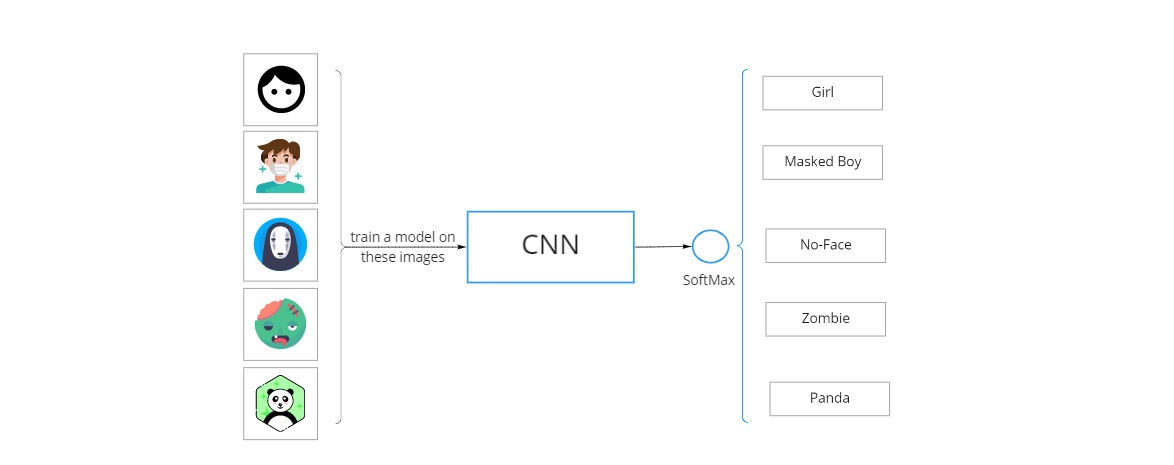

-- Figure 5: Usual approach for CNN training --

Issues with the implementation above for the given problem:
- would not work well for a small training set
- would need retraining when we need to recognize new persons, right ? Because our output layer learned to predict a fixed number of classes. New class, new training.

**Better alternative: Similarity Function**  
The alternative to learning what each class looks like is to learn a similarity function, a function of the degree of difference between images. 

The output of such a function would be something like:  
d(picture_1, picture_2) = the degree of difference between two pictures. 

Afterwards, the facial recognition function would compare the degree of difference between the new input image and an image from our database.  
If d < thereshold => it's the same person.

### Siamese Network

To compute the degree of difference, we could compare pixel by pixel. But this would not give the best results when we deal with different pose, different illumination etc for the same person.  

A better alternative is called a Siamese Network (<a href='https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf'>Taigman et al 2014</a>). This method uses two identical CNNs that compute **embeddings** - vector encodings of the input image. And aftwrwards it compares the **distance** between these embeddings. 

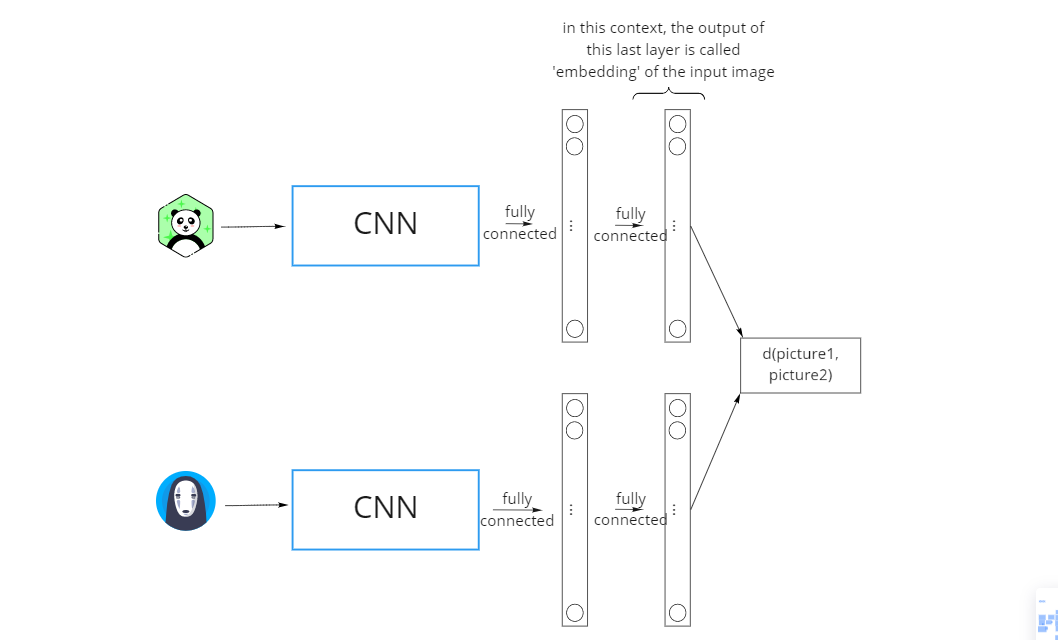

-- Figure 6: Siamese Network --

### The triplet function

So we're trying to train a neural network, to learn parameters (weights and biases for each layer) so that:
- when two different images of the same person are presented -> d(output1, output2) is small
- when two images of different persons are presented -> d(output1, output3) is large

So our final network will look like the one in Figure 7.  

The image we need to make a judgement on is called anchor.  
We compare it to an image of the person we're trying tp verify it against (positive image).  
And we compare it against a picture of a person who is not the same as in the anchor image (negative image).

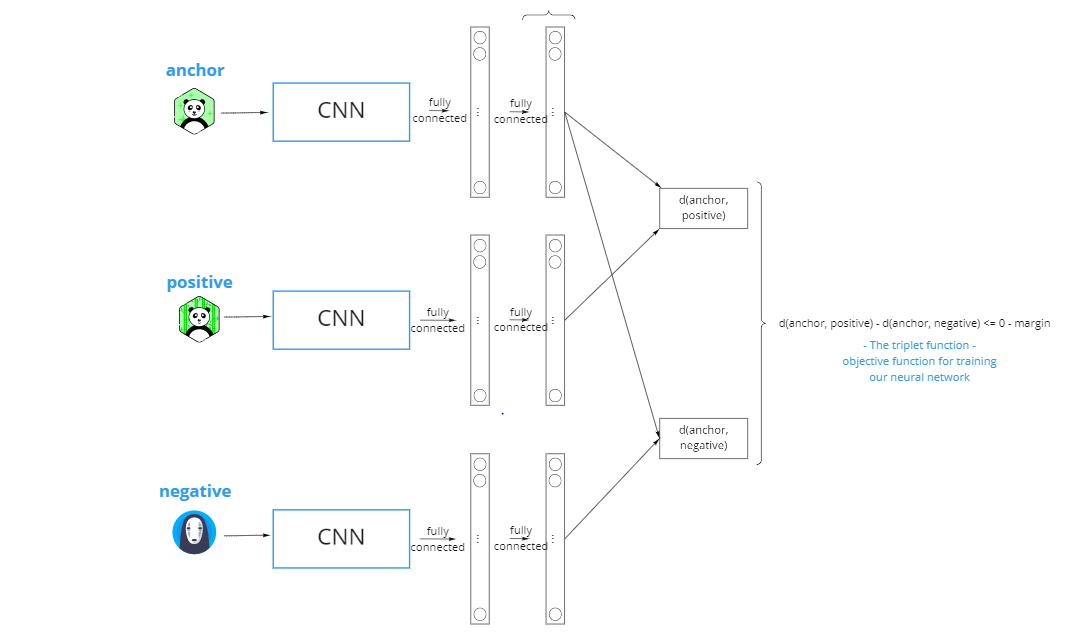
-- Figure 7: CNN for facial recognition --

Notice in the image above that, when we want:   

d(anchor,positive) - d(anchor,negative) <= 0 - margin 

The margin parameter is a standard method to prevent the network from learning the redundant solution: if we asked the network simply to have the left side of the equation <= 0, it could learn the solution of outputting 0 for the distance every time, regardless of the input. The margin makes sure d=0 will not be the solution the network converges to.

As the outputs of the network are embeddings (vectors), we will compute the distance between them as the L2 norm of the difference between the two vectors.

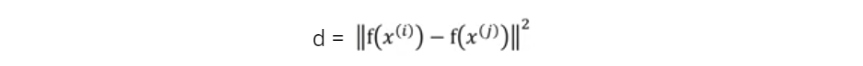

Now let's continue to build our network from where we left off, from the *transfer_inception_model*, which was built from a pretrained InceptionV3 without the top layer plus 3 additional Dense layers to be trained for the new task.  

We need to 'assemble' the network from Figure 7 now.

In [ ]:
#our class will inherit from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
class SimilarityLayer(layers.Layer):
    # compute and return the two distances:
    # d(anchor,positive) 
    # d(anchor,negative)
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        d1 = tf.reduce_sum(tf.square(anchor-positive), -1)
        d2 = tf.reduce_sum(tf.square(anchor-negative), -1)
        return(d1,d2)
    
anchor = layers.Input(name='anchor', shape = target_size + (3,))
positive = layers.Input(name='positive', shape = target_size + (3,))
negative = layers.Input(name='negative', shape = target_size + (3,))

sim_layer_output = SimilarityLayer().call(
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative))
)

siamese_model = Model(inputs=[anchor, positive,negative], outputs=sim_layer_output)

Wrap a custom Model class aroung the siamese_model above so that we can implement a custom training loop that optimizes the difference between distances.  

For the class definition below I used <a href='https://keras.io/guides/customizing_what_happens_in_fit/'>Keras' official documentation for writing your own training loop</a>.

In [ ]:
class SiameseModelClass(Model):
    def __init__(self, siamese_model, margin = 0.5):
        super(SiameseModelClass, self).__init__()
        
        self.siamese_model = siamese_model
        self.margin = margin
        
        # create a Metric instance to track the loss
        self.loss_tracker = metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_model(inputs)
    
    # customize the training process: providing our own training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # call custom loss function
            loss = self.custom_loss(data)
            
        # Compute gradients
        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update our training loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # providing our own evaluation step
    def test_step(self, data):
        # call custom loss function
        loss = self.custom_loss(data)
        
        # Update our test loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # custom loss function
    def custom_loss(self, data):
        # get the distances tuple from the siamese model output
        d1, d2 = self.siamese_model(data)
        
        # compute the triplet loss
        loss = tf.maximum(d1 - d2 + self.margin, 0)
        
        return loss
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]

### Faces Dataset

For transfer learning and for testing the model on the face recognition task I want to use one of common datasets for this task.  

In the article introducing the FaceNet system (which made the Triplet function popular), <a href='https://arxiv.org/abs/1503.03832'>Schroff et al 2015</a> use two datasets: <a href='http://vis-www.cs.umass.edu/lfw/'>Labeled Faces in the Wild (LFW)</a> and <a href='https://www.cs.tau.ac.il/~wolf/ytfaces/'>YouTube Faces DB</a>. I will be using the LFW dataset. Mind that LFW official website warns that LFW is "a public benchmark for face verification" and not suitable for commercial-grade face recognition systems, but for the purpose of this Notebook it's good enough.    

LFW consists of 13.000 images collected from the internet. Each image is labelled with the name of the person in the image.  

The number of images per person varies. I assume there are people for which only one image is available. I will thus not use the whole dataset. I will first do a basic exploration of the dataset and then decide on the threshold of minimum number of images per person for selecting images for my dataset.  

According to <a href='http://vis-www.cs.umass.edu/lfw/'>LFW website</a>, there are multiple versions of this dataset, besides the original one. One of these versions contain "funneled images". <a href='http://vis-www.cs.umass.edu/deep_funnel.html'>Deep funneling</a> is a method to reduce within class variability, so I'm gonna work with this one, because I have limited computing power for transfer learning training, so I want to make my task easier.

First, download the dataset.

In [ ]:
#helper function
def download_and_uncompress_tarball(tarball_url, dataset_dir):
    """Downloads the `tarball_url` and uncompresses it locally.
    Args:
    tarball_url: The URL of a tarball file.
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = tarball_url.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (
            filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dataset_dir)

Download and uncompress the LFW dataset.

In [ ]:
# URL for sourcing the funneled images
database_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'

root_folder = '../working'
download_folder = root_folder + '/'+ 'data/lfw_original'
selection_folder = root_folder + '/' + 'data/lfw_selection'
download_path = download_folder + '/lfw-deepfunneled.tgz'

if not os.path.exists(download_folder):
    os.makedirs(download_folder)

if not os.path.exists(selection_folder):
    os.makedirs(selection_folder)
    
if not os.path.exists(download_path):
    download_and_uncompress_tarball(database_url, download_folder)

Extract the list of people in our dataset.

In [ ]:
extracted_folder = download_folder + '/lfw-deepfunneled'

# images are organized into separate folders for each person
# get a list of subfolders 
subfolders = [x[0] for x in os.walk(extracted_folder)]

# first item is root the folder itself
subfolders.pop(0) 

Now count the number of available images per person.

In [ ]:
people_list = []

for path in subfolders:
    image_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    people_list.append((path.split('\\')[-1], image_count))
    #people_count.append((path, image_count))
    
# Sort from max to min images per person
people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

Overview of the number of images in our dataset.

In [ ]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

*How many exemplars per class do we need ?*

For this problem, each training example will consist of a triplet of images: the anchor, the positive and the negative image.  

The anchor and the positive image are two different pictures from the same class.  

If one class has n exemplars, we can make this amount of anchor,positive pairs:

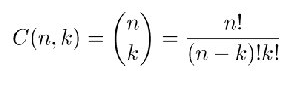

where k is 2 in our case.  

So, if we have 5 different images for a class, we will be able to compose 5! / ((5-2)!\*2! = 10 anchor-positive pairs.  

Then, to complete our triplet, we will select one random image from any other class expect the one we got the anchor from.

Select the people with at least 5 images. Then select the first five images for each. Move them all to a new location.

In [ ]:
# dictionary of selected persons, where 
# - key = rank
# - value = list of names of the image files for this person
selected_persons = {}
i = 0

for person,image_count in people_list:
    if image_count >=5:
        file_list = []
        
        # create new folder in selected images path
        newpath = selection_folder + '/' + person.split('/')[-1]
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        # copy / paste first 5 images to the new location
        files = [os.path.join(person, f) for f in os.listdir(person) if os.path.isfile(os.path.join(person, f))]
        files = files[0:5] # select first 5 images
        for file in files:
            filename = file.split('/')[-1]
            shutil.copyfile(file, newpath + '/' + filename)
            file_list.append(newpath + '/' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

Generate the list of (anchor, positive, negative) triplets for our training and testing.  

For anchor and positive we generate all combinations of two from the 5 available images per person. 

For the negative, we choose a random class and a random image rank (of the 5 images we have per class).

In [ ]:
triplets = []

for item in selected_persons.items():
    images = item[1]
    
    for i in range(len(images)-1):
        for j in range(i+1,len(images)):
            anchor = images[i]
            positive = images[j]
            
            # choose a random negative
            # first generate a random class rank and make sure we're not selecting the current class
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
            # selected a random image from the 5 that any of our classes has
            random_image = random.randint(0, 4)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))

Visualize a few of our triplets.

In [ ]:
# helper function for needed preprocessing of our jpg images
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [ ]:
def plot_images(triplets):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(5, 3)
    
    for i in range(0,5):
        anchor,positive,negative = triplets[40+i]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

In [ ]:
plot_images(triplets)

In [ ]:
# helper function for transforming a tuple of filenames 
# into a tuple of corresponding tensors
def preprocess_triplets(anchor, positive, negative):
    """
    Inputs: a tuple of filenames
    Output: a tuple of preprocessed images 
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

Remember our images were in sorted in a specific way:
- we have 10 tuples from each class 
- classes were sorted in alphabetical order
- images in each class were also sorted in alphabetical order  
So far we did not alter this ordering. But we want to start training on a randomized dataset.

In [ ]:
rng = np.random.RandomState(seed=101)
rng.shuffle(triplets)

These are just some transformations specific to TF data structures. 

In [ ]:
anchor_images = [a_tuple[0] for a_tuple in triplets]
positive_images = [a_tuple[1] for a_tuple in triplets]
negative_images = [a_tuple[2] for a_tuple in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

Let's now split our dataset into train and validation.

In [ ]:
training_data = dataset.take(round(image_count * 0.8))
validation_data = dataset.skip(round(image_count * 0.8))

training_data = training_data.batch(32, drop_remainder=False)
training_data = training_data.prefetch(8)

validation_data = validation_data.batch(32, drop_remainder=False)
validation_data = validation_data.prefetch(8)

In the FaceNet paper, <a href='https://arxiv.org/abs/1503.03832'>Schroff et al 2015</a> describe a more professional method to select triplets. Ideally, the negative that accompanies a pair of anchor and positive should be a difficult negative, not just a random image. I implemented the method above only for simplicity.

## Training

Now we're ready to train our model.

In [ ]:
# training on CPU will take a bit longer
# use this code only if you ran out of GPU time
'''
import time
start_time = time.time()

epochs = 15

siameze_custom_model = SiameseModelClass(siamese_model)
siameze_custom_model.compile(optimizer = optimizers.Adam(0.0001))
siameze_custom_model.fit(training_data, epochs=epochs, validation_data = validation_data)

stop_time = time.time()
print(f'It took {(stop_time - start_time)} to train for {epochs} epochs.')
'''

In [ ]:
# use the GPU training instead

model_on_GPU = SiameseModelClass(siamese_model)
model_on_GPU.compile(optimizer = optimizers.Adam(0.0001))
#model_on_GPU.fit(training_data, epochs=epochs, validation_data = validation_data)

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

In [ ]:
import time
start = time.time()

epochs = 15
with tf.device('/gpu:0'):
    history = model_on_GPU.fit(
        training_data, 
        epochs=epochs, 
        validation_data = validation_data
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Visualize training results

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### What did our network learn ?

Our network learned to produce embeddings that maximize the following function for a tuple of three images received as input (anchor, positive, negative):  



That is, embeddings for the anchor and the positive image should be closer together than embeddings for the anchor and the negative image.  

In [ ]:
sample = next(iter(training_data))
#plot_images(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative)),
)

Check the embeddings distances learned by the model.  
We expect the difference between anchor and positive image to be larger than the distance between the anchor and the negative example.

In [ ]:
d1 = np. sum(np. power((anchor_embedding-positive_embedding),2))
print(f'Anchor-positive difference = {d1}')

d2 = np. sum(np. power((anchor_embedding-negative_embedding),2))
print(f'Anchor-negative difference = {d2}')

Also look at cosine similarity for each pair of embeddings learned by the model. This time we expect the first value to be larger than the second value (now we're talking about similarity; it's not the difference anymore)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

## Conclusions

We can see from the training output that validation error increased right from the start, which is definitely not a god sign. It looks like overfitting right from the start. It could be the case that I am using a too complicated network for a too simple dataset.  

Remember we took a pretrained inception model, removed the top layer and added a few more Dense layers. Remember that I also fixed all other layers except for these Dense layers at the end, so I'm only training these ones. Maybe the Dense layers are too large or I used too many of them and my dataset is too simple for this. There are some standard measures to prevent overfitting, but I will address those in another Notebook.